# 파일 다운로드

In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1WNqV8300sC_q7jl11Tu3Ed3qlHvTIm5P --output data.zip

Downloading...
From: https://drive.google.com/uc?id=1WNqV8300sC_q7jl11Tu3Ed3qlHvTIm5P
To: /content/data.zip
100% 97.2k/97.2k [00:00<00:00, 36.0MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('data.zip', 'r') as existing_zip:
    existing_zip.extractall('data')

# **-필요 모듈 설치 및 Import**

In [ ]:
!pip install catboost
!pip install pycaret
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime as dt
from pycaret.regression import *

     |████████████████████████████████| 69.2MB 46kB/s 
     |████████████████████████████████| 266kB 4.1MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 6.8MB 18.0MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 1.7MB 37.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.2MB 214kB/s 
     |████████████████████████████████| 2.0MB 32.7MB/s 
     |████████████████████████████████| 1.4MB 37.4MB/s 
     |████████████████████████████████| 256kB 49.1MB/s 
     |████████████████████████████████| 276kB 35.3MB/s 
     |████████████████████████████████| 112kB 56.4MB/s 
     |████████████████████████████████| 174kB 27.9MB/s 
     |████████████████████████████████| 1.2MB 37.0MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 

# **-데이터 로드 및 피쳐 생성**

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train[['현본사소속재택근무자수', '중식계', '석식계']] = train[['현본사소속재택근무자수', '중식계', '석식계']].astype('int')
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype('int')

train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday
test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

print('done')

done


# **-변수 간 관계 시각화**

### **일-석식계 간 관계**

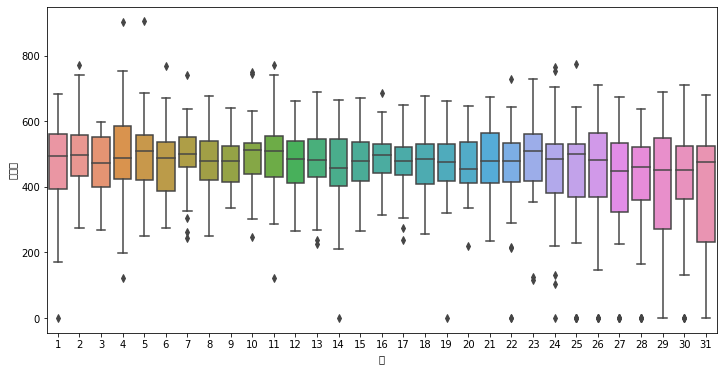

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(train['일'], train['석식계'])

## **주-석식계 간 관계**

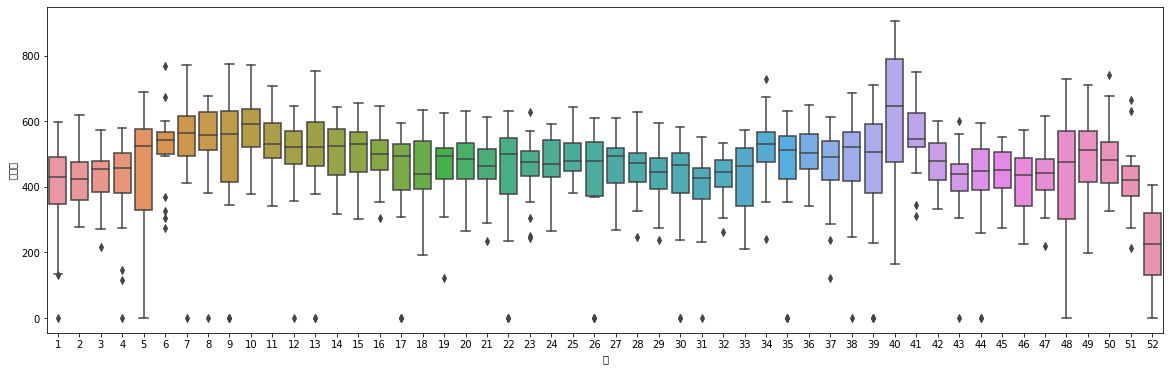

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(train['주'], train['석식계'])

## **월-석식계 간 관계**

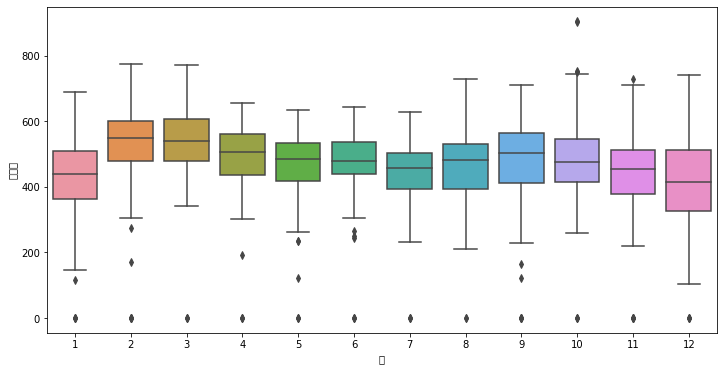

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(train['월'], train['석식계'])

## **년도-석식계 간 관계**

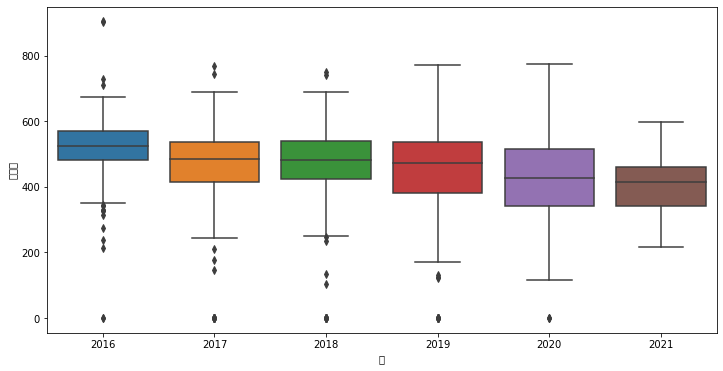

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(train['년'], train['석식계'])

## **야근인원수-석식계 간 관계**

<Figure size 864x432 with 0 Axes>

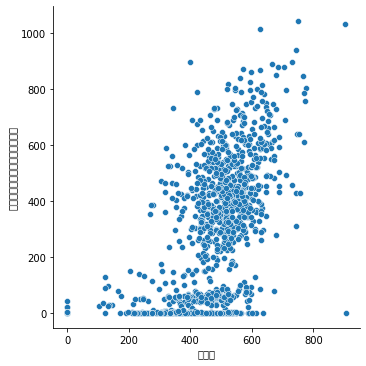

In [ ]:
plt.figure(figsize=(12,6))
sns.relplot(train['석식계'], train['본사시간외근무명령서승인건수'])

# **-NLP**

* **원핫인코딩으로 메뉴 분류하면 좋은 듯**

-------------------------------------------------------------

* **2021.06.12 기준**
* **메뉴의 종류를 원-핫 인코딩으로 분류시켜서 학습시키니 성능 상승**
* **'주' 및 '월' 데이터를 추가해서 연초 연말 월초 월말 알아서 학습 유도**

##**메뉴 임베딩**

In [ ]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

train['중식메뉴_split'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_split'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [ ]:
test['중식메뉴_split'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_split'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [ ]:
train['중식메뉴_split'][0]

['포기김치', '쌀밥', '계란찜', '쇠불고기', '요구르트', '잡곡밥', '청포묵무침', '오징어찌개']

In [ ]:
lunch_lst = []
lunch_count = []
pref = 0
for i in tqdm(range(1205)):
  try:
    if train['중식계'][i] >= 880:
      pref = 1
    else:
      pref = 0

    lunch_lst.append(train['중식메뉴_split'][i])
    lunch_count.append(pref)
  except:
    pass
# for i in range(len(lunch_lst)):
  # lunch_lst[i] = lunch_lst[i].replace(',', ' ')
print('done')


done


In [ ]:
dinner_lst = []
dinner_count = []
pref_d = 0
for i in tqdm(range(1205)):
  try:
    if train['석식계'][i] > 476:
      pref_d = 1
    else:
      pref_d = 0

    dinner_lst.append(train['석식메뉴_split'][i])
    dinner_count.append(pref_d)
  except:
    pass
# for i in range(len(dinner_lst)):
#   dinner_lst[i] = dinner_lst[i].replace(',', ' ')
print('done')


done


In [ ]:
lunch_lst_test = []
lunch_count_test = []
for i in tqdm(range(50)):
  try:
    lunch_lst_test.append(test['중식메뉴_split'][i])
    lunch_count_test.append(0)
  except:
    pass
# for i in range(len(lunch_lst_test)):
#   lunch_lst_test[i] = lunch_lst_test[i].replace(',', ' ')
print('done')


done


In [ ]:
dinner_lst_test = []
dinner_count_test = []
for i in tqdm(range(50)):
  try:
    dinner_lst_test.append(test['석식메뉴_split'][i])
    dinner_count_test.append(0)
  except:
    pass
# for i in range(len(dinner_lst_test)):
#   dinner_lst_test[i] = dinner_lst_test[i].replace(',', ' ')
print('done')


done


In [ ]:
lunch_df = pd.DataFrame({'중식메뉴':lunch_lst})
dinner_df = pd.DataFrame({'석식메뉴':dinner_lst})
lunch_df_t = pd.DataFrame({'중식메뉴':lunch_lst_test})
dinner_df_t = pd.DataFrame({'석식메뉴':dinner_lst_test})

## **모든 메뉴의 분류**

In [ ]:
menu = pd.read_csv('/content/data/pinkcoding_data_menu.csv', encoding='cp949')

In [ ]:
food = list(menu['메뉴'])
result_lunch = []
result_dinner = []
for k in range(len(lunch_df)):
  trigger = np.zeros(34, dtype='int')
  for i in range(len(lunch_df.iloc[k][0])):
    if lunch_df.iloc[k][0][i] in food:
      trigger += np.array(menu[menu['메뉴'] == lunch_df.iloc[k][0][i]].iloc[0][1:-1], dtype='int')
  trigger = trigger / trigger.sum()
  result_lunch.append(trigger)

for k in range(len(dinner_df)):
  trigger = np.zeros(34, dtype='int')
  for i in range(len(dinner_df.iloc[k][0])):
    if dinner_df.iloc[k][0][i] in food:
      trigger += np.array(menu[menu['메뉴'] == dinner_df.iloc[k][0][i]].iloc[0][1:-1], dtype='int')
  trigger = trigger / trigger.sum()
  result_dinner.append(trigger)

In [ ]:
result_lunch_t = []
result_dinner_t = []
for k in range(len(lunch_df_t)):
  trigger = np.zeros(34, dtype='int')
  for i in range(len(lunch_df_t.iloc[k][0])):
    if lunch_df_t.iloc[k][0][i] in food:
      trigger += np.array(menu[menu['메뉴'] == lunch_df_t.iloc[k][0][i]].iloc[0][1:-1], dtype='int')
  trigger = trigger / trigger.sum()
  result_lunch_t.append(trigger)

for k in range(len(dinner_df_t)):
  trigger = np.zeros(34, dtype='int')
  for i in range(len(dinner_df_t.iloc[k][0])):
    if dinner_df_t.iloc[k][0][i] in food:
      trigger += np.array(menu[menu['메뉴'] == dinner_df_t.iloc[k][0][i]].iloc[0][1:-1], dtype='int')
  trigger = trigger / trigger.sum()
  result_dinner_t.append(trigger)

## **메뉴 데이터 생성**

In [ ]:
column = list(menu.columns[1:-1])
lunch_sort = pd.DataFrame(result_lunch ,columns=column)
dinner_sort = pd.DataFrame(result_dinner, columns = column)
lunch_sort_t = pd.DataFrame(result_lunch_t, columns=column)
dinner_sort_t = pd.DataFrame(result_dinner_t, columns = column)

# **-Feature Engineering**

##**문화의 날**


*   매달 마지막 주 수요일 문화의 날 지정
*   석식 0명인 Feature 발견
*   ----------------------------
*   따로 지정하지 않아도 일, 주 데이터로 학습이 됨!!




In [ ]:
# train = train[train['석식계'] != 0]

In [ ]:
# train['문화의날'] = 0
# test['문화의날'] = 0

In [ ]:
# a = train[(train['일'] > 25)  & (train['요일'] == 2)].index
# a = list(a)

In [ ]:
# b = test[(test['일'] > 25) & (test['요일'] == 2)].index

In [ ]:
# b = list(b)

In [ ]:
# train['문화의날'][a] = 1

In [ ]:
# test['문화의날'][b] = 1

## **강수량 및 기온 Feature Generating**

*   외부 데이터(기상청) 사용
*   기온 및 강수량에 따라 중식계 영향을 미칠 것으로 예상
*   본거지가 진주가 아닌 사원들이 많아 기숙사 생활 인원이 많음
*   따라서 강수량 및 기온은 크게 영향 미치지 않을 것으로 추정


In [ ]:
rain_2016 = pd.read_csv('/content/drive/MyDrive/2016강수량.csv')
rain_2017 = pd.read_csv('/content/drive/MyDrive/2017강수량.csv')
rain_2018 = pd.read_csv('/content/drive/MyDrive/충무공동_강수_201801_201812.csv')
rain_2019 = pd.read_csv('/content/drive/MyDrive/충무공동_강수_201901_201912.csv')
rain_2020 = pd.read_csv('/content/drive/MyDrive/충무공동_강수_202001_202012.csv')
rain_2021 = pd.read_csv('/content/drive/MyDrive/충무공동_강수_202001_202012.csv')

tem_2016 = pd.read_csv('/content/drive/MyDrive/충무공동_기온_201602_201612.csv')
tem_2017 = pd.read_csv('/content/drive/MyDrive/충무공동_기온_201701_201712.csv')
tem_2018 = pd.read_csv('/content/drive/MyDrive/충무공동_기온_201801_201812.csv')
tem_2019 = pd.read_csv('/content/drive/MyDrive/충무공동_기온_201901_201912.csv')
tem_2020 = pd.read_csv('/content/drive/MyDrive/충무공동_기온_202001_202012.csv')
tem_2021 = pd.read_csv('/content/drive/MyDrive/충무공동_기온_202101_202101.csv')

In [ ]:
def rain_chart_maker(df, n):
  key = {}
  lst_rain = []
  c = df[(df['hour'] == 1100) & (df[df.columns[2]] > 5)]
  for i in range(len(c.index)):
    month_r = str(int((c.index[i]//24)/30) + 2)
    try:
      day_r = df[' format: day'][c.index[i]].lstrip()
    except:
      pass
    year = str(n)
    try:
      if (int((c.index[i]//24)/30) + 2) < 10 and (int(df[' format: day'][c.index[i]]) < 10):
        key[pd.to_datetime(year + '-0' + month_r +'-0'+day_r)] = df[df.columns[2]][c.index[i]]
        lst_rain.append(pd.to_datetime(year + '-0' + month_r +'-0'+day_r))
        # key.append({year + '-0' + month_r +'-0'+day_r : df[df.columns[2]][c.index[i]]})
      if (int((c.index[i]//24)/30) + 2) >= 10 and (int(df[' format: day'][c.index[i]]) < 10):
        key[pd.to_datetime(year + '-' + month_r +'-0'+day_r)] = df[df.columns[2]][c.index[i]]
        lst_rain.append(pd.to_datetime(year + '-' + month_r +'-0'+day_r))
        # key.append({year + '-' + month_r +'-0'+day_r :  df[df.columns[2]][c.index[i]]})
      if (int((c.index[i]//24)/30) + 2) < 10 and (int(df[' format: day'][c.index[i]]) >= 10):
        key[pd.to_datetime(year + '-0' + month_r +'-'+day_r)] = df[df.columns[2]][c.index[i]]
        lst_rain.append(pd.to_datetime(year + '-0' + month_r +'-'+day_r))
        # key.append({year + '-0' + month_r +'-'+day_r : df[df.columns[2]][c.index[i]]})
      if (int((c.index[i]//24)/30) + 2) >= 10 and (int(df[' format: day'][c.index[i]]) >= 10):
        lst_rain.append(pd.to_datetime(year + '-' + month_r +'-'+day_r))
        key[pd.to_datetime(year + '-' + month_r +'-'+day_r)] = df[df.columns[2]][c.index[i]]
        # key.append({year + '-' + month_r +'-'+day_r:df[df.columns[2]][c.index[i]]})
    except:
      pass
  return key, lst_rain


In [ ]:
key_2016, lst_2016 = rain_chart_maker(rain_2016, 2016)
key_2017, lst_2017 = rain_chart_maker(rain_2017, 2017)
key_2018, lst_2018 = rain_chart_maker(rain_2018, 2018)
key_2019, lst_2019 = rain_chart_maker(rain_2019, 2019)
key_2020, lst_2020 = rain_chart_maker(rain_2020, 2020)
key_2021, lst_2021 = rain_chart_maker(rain_2021, 2021)

key_t_2016, lst_t_2016 = rain_chart_maker(tem_2016, 2016)
key_t_2017, lst_t_2017 = rain_chart_maker(tem_2017, 2016)
key_t_2018, lst_t_2018 = rain_chart_maker(tem_2018, 2016)
key_t_2019, lst_t_2019 = rain_chart_maker(tem_2019, 2016)
key_t_2020, lst_t_2020 = rain_chart_maker(tem_2020, 2016)
key_t_2021, lst_t_2021 = rain_chart_maker(tem_2021, 2016)

In [ ]:
train['강수량'] = 0
test['강수량'] = 0
train['기온'] = 0
test['기온'] = 0

In [ ]:
for i in lst_t_2021:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2021[i]
for i in lst_t_2020:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2020[i]
for i in lst_t_2019:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2019[i]
for i in lst_t_2018:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2018[i]
for i in lst_t_2017:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2017[i]
for i in lst_t_2016:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2016[i]
for i in lst_t_2021:
  for k in test['일자']:
      if i == k:
        test['기온'][test[test['일자']==k].index[0]] = key_t_2021[i]
print('done')

done


In [ ]:
for i in lst_2021:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2021[i]
for i in lst_2020:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2020[i]
for i in lst_2019:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2019[i]
for i in lst_2018:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2018[i]
for i in lst_2017:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2017[i]
for i in lst_2016:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2016[i]
for i in lst_2021:
  for k in test['일자']:
      if i == k:
        test['강수량'][test[test['일자']==k].index[0]] = key_2021[i]
print('done')

done


## **공휴일 전후 데이터 추가**


*   테스트 데이터에 설날 연휴, 어린이날 존재
*   연휴 전날 1로 인코딩 나머지 0





In [ ]:
train['공휴일전후'] = 0
test['공휴일전후'] = 0

공휴일 지정 노가다....

In [ ]:
train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 2
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 2
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 2
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

test['공휴일전후'][10] =2
test['공휴일전후'][20] = 1

**원핫인코딩**

In [ ]:
train = pd.get_dummies(train, columns=['공휴일전후'])
test = pd.get_dummies(test, columns=['공휴일전후'])

In [ ]:
test['공휴일전후_0'][20] = 1
test['공휴일전후_1'][20] = 0

# **-Train Data Set & Test Data Set**

## **데이터 지정**

*   중식은 주52시간 탄련근무제에 영향 안받음
*   석식은 591번째 데이터 이후 (2018.07.01) 이후 부터 정의
*   메뉴 데이터 포함
----------------------------------------------------------------
*   탄력근무제 반영하지 않은 FULL 석식 데이터에서 더 높은 성능을 보임



In [ ]:
# -----------------------------<Full DATA>-----------------------------------

train_lunch = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년', '중식계']]
test_lunch = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년']]

train_dinner = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수', '석식계','일', '주', '월', '년']]
test_dinner = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수','일', '주', '월', '년']]

In [ ]:
# ------------------------<AFTER 2018.07.01 DATA>----------------------------

# train_1 = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년', '중식계']][591:]
# test_1 = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년']]

# train_2 = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수', '석식계','일', '주', '월', '년']][591:]
# test_2 = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수','일', '주', '월', '년']]

In [ ]:
#메뉴
train_lunch = pd.concat([train_lunch, lunch_sort], axis = 1)
train_dinner = pd.concat([train_dinner, dinner_sort], axis = 1)
test_lunch = pd.concat([test_lunch, lunch_sort_t], axis = 1)
test_dinner = pd.concat([test_dinner, dinner_sort_t], axis = 1)
print('done')

done


## **중식 모델링**

In [ ]:
train_lunch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 50 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   요일           1205 non-null   int64  
 1   공휴일전후_0      1205 non-null   uint8  
 2   휴가비율         1205 non-null   float64
 3   출장비율         1205 non-null   float64
 4   재택비율         1205 non-null   float64
 5   공휴일전후_2      1205 non-null   uint8  
 6   공휴일전후_1      1205 non-null   uint8  
 7   출근           1205 non-null   int64  
 8   본사출장자수       1205 non-null   int64  
 9   현본사소속재택근무자수  1205 non-null   int64  
 10  본사휴가자수       1205 non-null   int64  
 11  일            1205 non-null   int64  
 12  주            1205 non-null   int64  
 13  월            1205 non-null   int64  
 14  년            1205 non-null   int64  
 15  중식계          1205 non-null   int64  
 16  곡류           1203 non-null   float64
 17  두류           1203 non-null   float64
 18  난류           1203 non-null   float64
 19  묵류    

In [ ]:
reg = setup(data=train_lunch,
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,1978
1,Target,중식계
2,Original Data,"(1205, 50)"
3,Missing Values,True
4,Numeric Features,43
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 65)"


In [ ]:
best_5_l = compare_models(sort='MAE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,6.933270e+01,8.737664e+03,9.294470e+01,7.989000e-01,0.1186,8.640000e-02,3.295
gbr,Gradient Boosting Regressor,7.113080e+01,9.139276e+03,9.495740e+01,7.882000e-01,0.1207,8.800000e-02,0.230
huber,Huber Regressor,7.406720e+01,1.045964e+04,1.018139e+02,7.612000e-01,0.1288,9.170000e-02,0.074
lightgbm,Light Gradient Boosting Machine,7.445280e+01,9.978650e+03,9.914480e+01,7.700000e-01,0.1243,9.150000e-02,0.144
rf,Random Forest Regressor,7.470010e+01,1.037514e+04,1.013300e+02,7.597000e-01,0.1301,9.300000e-02,1.012
et,Extra Trees Regressor,7.499190e+01,1.071918e+04,1.030011e+02,7.522000e-01,0.1303,9.240000e-02,0.808
ridge,Ridge Regression,7.528150e+01,1.023645e+04,1.007816e+02,7.675000e-01,0.1272,9.330000e-02,0.015
lasso,Lasso Regression,7.544860e+01,1.030565e+04,1.011372e+02,7.661000e-01,0.1264,9.310000e-02,0.018
br,Bayesian Ridge,7.546600e+01,1.022732e+04,1.007519e+02,7.679000e-01,0.1268,9.340000e-02,0.023
omp,Orthogonal Matching Pursuit,7.683420e+01,1.091047e+04,1.041566e+02,7.516000e-01,0.1300,9.460000e-02,0.015


### **앙상블 모델**

In [ ]:
blended_l = blend_models(estimator_list= best_5_l, fold=5, optimize='MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_lunch)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,68.2846,8229.7357,90.7179,0.7951,0.1072,0.0804
1,70.1591,9602.4059,97.9919,0.8038,0.1334,0.0904
2,74.3421,9622.7516,98.0956,0.7844,0.1169,0.0875
3,63.6363,7347.7841,85.7192,0.8125,0.1186,0.0819
4,70.7891,9085.9003,95.3200,0.8239,0.1187,0.0889
Mean,69.4422,8777.7155,93.5689,0.8039,0.1189,0.0858
SD,3.5039,875.6899,4.7511,0.0136,0.0084,0.0040


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,65.3561,7489.2231,86.5403,0.8183,0.1046,0.0771


In [ ]:
pred_esb_l['Label']

0     1004.276903
1      884.135105
2      635.752445
3     1287.341946
4     1030.694455
5     1036.677121
6      985.950300
7      753.865085
8     1309.878422
9     1085.104712
10     751.187659
11    1304.834032
12    1078.321271
13    1079.834437
14     912.094566
15     713.188036
16    1263.753155
17    1032.908757
18     980.516663
19     895.684862
20     664.195613
21    1075.411910
22    1001.834703
23     935.314419
24     734.622390
25    1273.807905
26    1036.315953
27     990.499065
28     909.692321
29     745.893690
30    1277.469761
31    1028.626346
32    1066.934359
33     915.459788
34     679.600347
35    1258.782510
36     995.428154
37     948.054724
38     851.449793
39     626.113387
40    1209.007017
41    1016.270056
42     963.441791
43     859.076403
44     642.731615
45    1232.480271
46    1018.236433
47     985.785363
48     878.489347
49     630.328064
Name: Label, dtype: float64

In [ ]:
submission_esb = pd.read_csv('data/sample_submission.csv')
submission_esb['중식계'] = pred_esb_l['Label']

## **석식 모델링**

In [ ]:
reg = setup(data=train_dinner,
            target='석식계', 
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,8738
1,Target,석식계
2,Original Data,"(1205, 51)"
3,Missing Values,True
4,Numeric Features,44
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 68)"


In [ ]:
best_5_d = compare_models(sort = 'MAE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,46.9567,4472.5444,66.1229,0.7838,0.6809,0.1104,4.633
gbr,Gradient Boosting Regressor,48.0411,4581.8141,66.9545,0.7782,0.7023,0.1126,0.259
rf,Random Forest Regressor,48.4957,4886.2868,68.9103,0.7646,0.4974,0.1167,1.053
lightgbm,Light Gradient Boosting Machine,49.1617,4830.7063,68.6447,0.7667,0.5805,0.1166,0.152
et,Extra Trees Regressor,49.2552,5332.1483,72.2040,0.7444,0.4161,0.1165,0.832
huber,Huber Regressor,50.3191,5619.3968,73.7810,0.7290,0.7557,0.1216,0.071
ridge,Ridge Regression,50.8814,5257.4237,71.6563,0.7469,0.8334,0.1180,0.016
br,Bayesian Ridge,50.9553,5275.4598,71.7667,0.7460,0.8336,0.1182,0.022
lr,Linear Regression,51.5749,5745.5067,74.7329,0.7223,0.8029,0.1230,0.017
lasso,Lasso Regression,52.2015,5384.7022,72.5837,0.7408,0.8393,0.1223,0.027


### 앙상블 모델

In [ ]:
blended_d = blend_models(estimator_list = best_5_d, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_dinner)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,44.3648,4879.7042,69.8549,0.7953,0.8071,0.1012
1,40.6899,3712.7585,60.9324,0.7978,0.3851,0.0985
2,49.9478,5029.3726,70.9181,0.7537,0.6405,0.1157
3,49.2257,4566.9783,67.5794,0.7734,0.5641,0.1207
4,46.5838,3945.7369,62.8151,0.8148,0.6743,0.1141
Mean,46.1624,4426.9101,66.4200,0.7870,0.6142,0.1100
SD,3.3785,515.5856,3.9111,0.0212,0.1390,0.0086


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,43.7736,3477.1082,58.967,0.7764,0.3983,0.1012


In [ ]:
pred_esb_d = predict_model(final_model_d, test_dinner)

In [ ]:
submission_esb['석식계'] = pred_esb_d['Label']
submission_esb

,일자,중식계,석식계
0,2021-01-27,1004.276903,376.426586
1,2021-01-28,884.135105,452.295420
2,2021-01-29,635.752445,242.125433
3,2021-02-01,1287.341946,534.180582
4,2021-02-02,1030.694455,474.103891
5,2021-02-03,1036.677121,10.437976
6,2021-02-04,985.950300,451.439057
7,2021-02-05,753.865085,425.490090
8,2021-02-08,1309.878422,598.785936
9,2021-02-09,1085.104712,513.535161


In [ ]:
submission_esb.to_csv('submission.csv', index = False)

# **간단한 시각화**

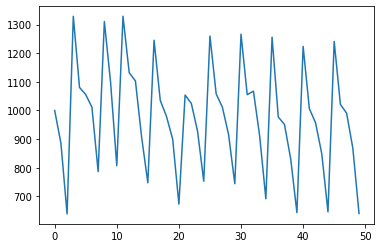

In [ ]:
submission_esb['중식계'].plot()

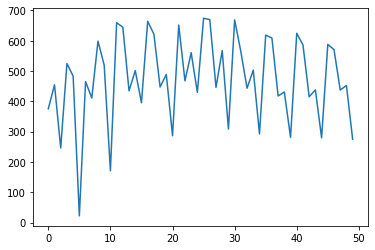

In [ ]:
submission_esb['석식계'].plot()